## Airbnb project

In [54]:
import pandas as pd
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import seaborn as sns

In [55]:
hood = gpd.read_file('neighbourhoods.geojson')
metro = gpd.read_file('metro.geojson')
trains = gpd.read_file('comboios.geojson')
df = pd.read_csv('listings.csv')

# Metro dataset

In [56]:
df2 = metro.copy()
for i in range(len(df2)):
    if not '/' in df2['LINHA'][i]:
        df2.drop([i], axis=0, inplace=True)
df2 = df2.reset_index()

In [57]:
for i in range(len(metro)):
    if '/' in  metro['LINHA'][i]:
        metro['LINHA'][i] = metro['LINHA'][i].split('/')[0]

for j in range(len(df2)):
    df2['LINHA'][j] = df2['LINHA'][j].split('/')[1]
    
metro = pd.concat([metro, df2])

/var/folders/10/b37vvtzs1hx0zykkgsrfypbr0000gn/T/ipykernel_2753/857219963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metro['LINHA'][i] = metro['LINHA'][i].split('/')[0]
/var/folders/10/b37vvtzs1hx0zykkgsrfypbr0000gn/T/ipykernel_2753/857219963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['LINHA'][j] = df2['LINHA'][j].split('/')[1]


In [58]:
metro = pd.concat([metro, df2])

In [59]:
colors = {'Verde': 'green', 
          'Azul': 'blue', 
          'Azul/Verde': 'blue',
          'Amarela': 'red', 
          'Azul/Amarela': 'red',
          'Azul/Vermelha': 'blue',
          'Amarela/Vermelha': 'red',
          'Verde/Vermelha': 'green',
          'Amarela/Verde': 'red',
          'Vermelha': 'violet'
         }

In [60]:
metro['color_eng'] = (metro['LINHA']).map(colors)

In [61]:
yellow = metro[metro.LINHA == 'Amarela'].reset_index()
blue = metro[metro.LINHA == 'Azul'].reset_index()
green = metro[metro.LINHA == 'Verde'].reset_index()
red = metro[metro.LINHA == 'Vermelha'].reset_index()


<AxesSubplot:>

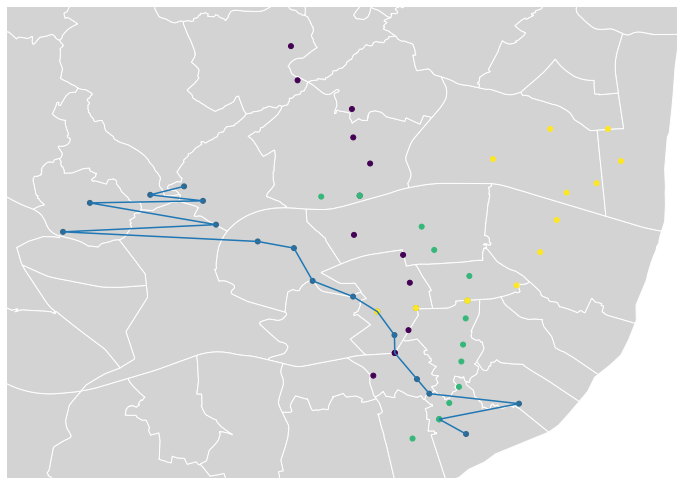

In [62]:
ax = geoplot.polyplot(hood, edgecolor='white', facecolor='lightgray', figsize=(12, 15))
geoplot.pointplot(metro, ax=ax, hue='LINHA')
gpd.GeoSeries([LineString(blue.geometry)]).plot(ax=ax)

# AIRBNB Dataset

In [63]:
df = df.drop(columns = ['host_name', 'host_id', 'license', 'id', 'name'])

In [64]:
df.isna().sum()

neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2506
reviews_per_month                 2506
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
dtype: int64

In [65]:
df = df.drop(columns = ['last_review', 'reviews_per_month'])

## One-hot encoding for room_type

In [66]:
from sklearn.preprocessing import OneHotEncoder

In [67]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['room_type']]).toarray())
df = df.join(enc_df)
#df = df.drop(columns=['room_type'])

In [68]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,0,1,2,3
0,Lisboa,Belm,38.697500,-9.197680,Entire home/apt,40,3,32,1,315,6,1.0,0.0,0.0,0.0
1,Lisboa,Santa Maria Maior,38.712410,-9.127060,Entire home/apt,50,2,127,1,325,14,1.0,0.0,0.0,0.0
2,Lisboa,Santa Maria Maior,38.710820,-9.127190,Entire home/apt,60,5,337,1,190,13,1.0,0.0,0.0,0.0
3,Lisboa,Santa Maria Maior,38.711560,-9.129870,Entire home/apt,60,2,299,1,302,40,1.0,0.0,0.0,0.0
4,Lisboa,Estrela,38.711080,-9.159790,Entire home/apt,957,2,64,2,248,9,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18522,Lisboa,Santo Antnio,38.721587,-9.143302,Entire home/apt,40,5,0,1,95,0,1.0,0.0,0.0,0.0
18523,Lisboa,Santa Maria Maior,38.716469,-9.132524,Entire home/apt,75,5,0,8,258,0,1.0,0.0,0.0,0.0
18524,Lisboa,Avenidas Novas,38.740442,-9.149162,Entire home/apt,150,1,0,1,0,0,1.0,0.0,0.0,0.0
18525,Lisboa,Santa Maria Maior,38.715410,-9.132390,Entire home/apt,55,1,0,4,246,0,1.0,0.0,0.0,0.0


In [69]:
Entire_home = df[df['room_type'] == 'Entire home/apt']

In [70]:
Entire_home

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,0,1,2,3
0,Lisboa,Belm,38.697500,-9.197680,Entire home/apt,40,3,32,1,315,6,1.0,0.0,0.0,0.0
1,Lisboa,Santa Maria Maior,38.712410,-9.127060,Entire home/apt,50,2,127,1,325,14,1.0,0.0,0.0,0.0
2,Lisboa,Santa Maria Maior,38.710820,-9.127190,Entire home/apt,60,5,337,1,190,13,1.0,0.0,0.0,0.0
3,Lisboa,Santa Maria Maior,38.711560,-9.129870,Entire home/apt,60,2,299,1,302,40,1.0,0.0,0.0,0.0
4,Lisboa,Estrela,38.711080,-9.159790,Entire home/apt,957,2,64,2,248,9,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18522,Lisboa,Santo Antnio,38.721587,-9.143302,Entire home/apt,40,5,0,1,95,0,1.0,0.0,0.0,0.0
18523,Lisboa,Santa Maria Maior,38.716469,-9.132524,Entire home/apt,75,5,0,8,258,0,1.0,0.0,0.0,0.0
18524,Lisboa,Avenidas Novas,38.740442,-9.149162,Entire home/apt,150,1,0,1,0,0,1.0,0.0,0.0,0.0
18525,Lisboa,Santa Maria Maior,38.715410,-9.132390,Entire home/apt,55,1,0,4,246,0,1.0,0.0,0.0,0.0


In [80]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf_lisboa = gdf[gdf.neighbourhood_group == 'Lisboa']
gdf_lisboa_low100 = gdf_lisboa[gdf_lisboa['price'] < 100]
gdf_lisboa_high100 = gdf_lisboa[gdf_lisboa['price'] > 100]
gdf = gdf.drop(columns = ['latitude', 'longitude'])

In [89]:
hotel = gdf_lisboa_low100[gdf_lisboa_low100['room_type'] == 'Hotel room']

128

In [72]:
gdf_lisboa.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,0,1,2,3
count,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000,12950.000000
mean,38.720461,-9.143047,90.848108,3.961853,58.986564,17.856834,218.536293,7.448108,0.773050,0.016834,0.198378,0.011737
std,0.014832,0.017792,185.325989,13.526214,82.542206,42.587576,129.733128,14.062075,0.418876,0.128654,0.398794,0.107706
min,38.691930,-9.226790,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.711260,-9.149720,48.000000,1.000000,4.000000,2.000000,102.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,38.715565,-9.140945,67.000000,2.000000,24.000000,5.000000,257.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,38.725680,-9.132780,98.000000,3.000000,84.000000,14.000000,339.000000,11.000000,1.000000,0.000000,0.000000,0.000000
max,38.792960,-9.092080,11499.000000,365.000000,1550.000000,281.000000,365.000000,821.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

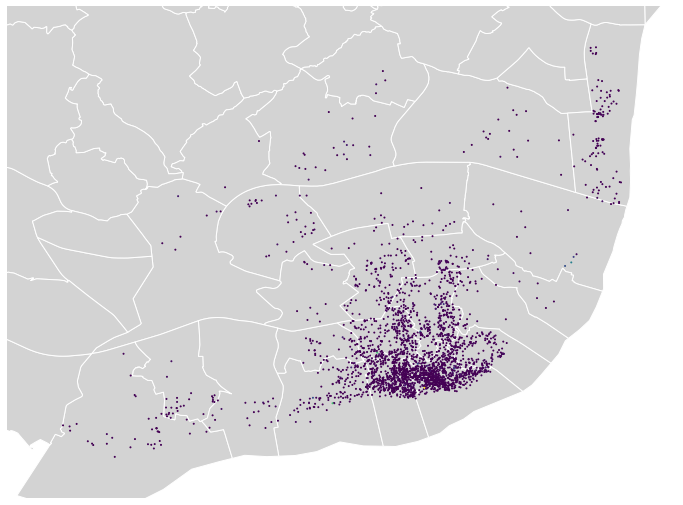

In [73]:
ax = geoplot.polyplot(hood, edgecolor='white', facecolor='lightgray', figsize=(12, 15))
geoplot.pointplot(gdf_lisboa_high300, ax=ax, hue='price', s=1)

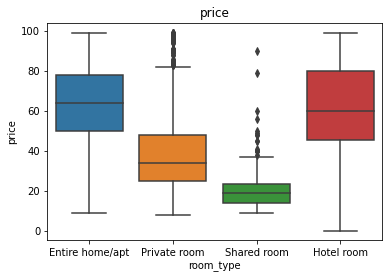

In [75]:
import seaborn as sns
#sns.displot(data = gdf_lisboa, x = 'price', kde=True).set(title = 'Price distribution');
sns.boxplot(data=gdf_lisboa_low100, y='price', x='room_type').set(title='price');

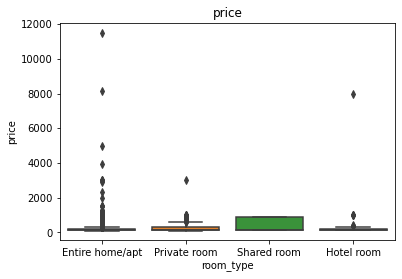

In [76]:
sns.boxplot(data=gdf_lisboa_high100, y='price', x='room_type').set(title='price');

In [79]:
len(gdf_lisboa_high100)

2862